# **Lab 2** - Commit Message Rectification for Bug-Fixing Commits in the Wild

**CS202 - Software Tools and Techniques for CSE**

Bhavya Parmar

23110059

In [1]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
from pydriller.repository import Repository
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [3]:
!git clone "https://github.com/Accenture/AmpliGraph.git"

Cloning into 'AmpliGraph'...
remote: Enumerating objects: 10845, done.
remote: Counting objects: 100% (1403/1403), done.
remote: Compressing objects: 100% (375/375), done.
remote: Total 10845 (delta 1081), reused 1202 (delta 1021), pack-reused 9442 (from 1)
Receiving objects: 100% (10845/10845), 43.36 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (7649/7649), done.


In [4]:
'''
Bug-fixing commit identification using pydriller
'''

repo_path = "/kaggle/working/AmpliGraph"
bug_fix_commits = pd.DataFrame(columns=['#', 'Message', 'Parent #', 'Merge Commit', 'Modified Files'])

for commit in Repository(repo_path).traverse_commits():
  res = re.search(r'''\b(((re|)solv(ed|es|e|ing))|(fix(ed|es|ing|s)?)|((bug|error|issue|typo|exception|conflict|problem)(s)?))\b''', commit.msg)

  if res:
    bug_fix_commits.loc[len(bug_fix_commits)] = [commit.hash, commit.msg, commit.parents[0], commit.merge, commit.modified_files]

bug_fix_commits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 314
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   #               315 non-null    object
 1   Message         315 non-null    object
 2   Parent #        315 non-null    object
 3   Merge Commit    315 non-null    bool  
 4   Modified Files  315 non-null    object
dtypes: bool(1), object(4)
memory usage: 12.6+ KB


In [5]:
bug_fix_commits.describe()

,#,Message,Parent #,Merge Commit,Modified Files
count,315,315,315,315,315
unique,315,243,308,2,243
top,311b614f85942b8b50c8a7e71bedf9aba7382bee,documentation fix,4b9d826cb4ceb1cb2ed98082e20631410307dcb9,False,[]
freq,1,14,3,295,20


In [6]:
bug_fix_commits.head()

,#,Message,Parent #,Merge Commit,Modified Files
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,5a2dbf8c312cc6774d24b61a04259b99c82c3365,False,[<pydriller.domain.commit.ModifiedFile object ...
1,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,bd9a60c629d31cb4e24005674c43bbdc6d9ef96c,False,[<pydriller.domain.commit.ModifiedFile object ...
2,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,0a95566bb5dc4e5d81fb02fb06803ed974213302,False,[<pydriller.domain.commit.ModifiedFile object ...
3,a6deac8ea192588a3ef119be08177434986b5963,fixed regularizer syntax error,8c5f964f01b9b7bc141db71789553c4cbbc29498,False,[<pydriller.domain.commit.ModifiedFile object ...
4,c56093ffe7de1333229ffa0696833a4303389f79,"Resolved spelling error, added missing steps a...",a6deac8ea192588a3ef119be08177434986b5963,False,[<pydriller.domain.commit.ModifiedFile object ...


In [7]:
bug_fix_commits.to_csv('bug_fix_commits.csv', index = False)

In [8]:
'''
Helper Functions
'''

def llm_inference(diff):
    '''
    Using CommitPredictorT5 model to predict fix type in commit
    '''
    tokenizer = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")
    model = AutoModelForSeq2SeqLM.from_pretrained("mamiksik/CommitPredictorT5").to(device) # Move model to device
    
    input_ids = tokenizer(diff, return_tensors="pt").input_ids.to(device) # Move input_ids to device
    
    generated_ids = model.generate(input_ids, max_length=20)
    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return output


GENERIC_PATTERN = re.compile(r"\b(update|changes?|modify|misc|stuff|minor|necessary|some)\b", re.IGNORECASE)

def need_rect(commit_msg, llm_msg, threshold=7):
    '''
    Decide if rectification is needed.
    Returns:
        * "yes"  - Rectification needed
        * "dev"  - Developer commit msg is apt
        * "llm"  - LLM inference is apt
    '''
    commit_msg_len = len(commit_msg.strip().split()) if commit_msg else 0
    llm_msg_len = len(llm_msg.strip().split()) if llm_msg else 0

    # Rule 1: Empty or too short (<3 words) → rectification
    if commit_msg_len < 3 and llm_msg_len < 3:
        return "yes"

    # Rule 2: Generic dev message → rectification
    if commit_msg and GENERIC_PATTERN.search(commit_msg):
        return "yes"

    # Rule 3: Prefer longer candidate above threshold
    if commit_msg_len >= threshold and commit_msg_len >= llm_msg_len:
        return "dev"
    elif llm_msg_len >= threshold:
        return "llm"

    # Rule 4: Both below threshold → pick longer if decent, else rectify
    if commit_msg_len >= llm_msg_len and commit_msg_len > 3:
        return "dev"
    elif llm_msg_len > 3:
        return "llm"

    return "yes"

In [ ]:
'''
Diff extraction and analysis
'''
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

diff_analysis = pd.DataFrame(columns=['#', 'Message', 'Filename', 'Source Code (before)',
                                      'Source Code (current)','Diff', 'Fix Type (LLM)',
                                      'Rectified Message'])

# Hit rates
dev_hit, llm_hit, rect_hit = 0, 0, 0

# Iterate over modified files in bug fixing commits
for _, row in bug_fix_commits.iterrows():
    commit_hash = row['#']
    parent_hash = row['Parent #']
    commit_msg = row['Message']
    modified_files = row['Modified Files']
    
    for file in modified_files:
        
        if file.diff is None or len(file.diff) > 6000:   # skip very large or empty diffs
            llm_output = "SKIPPED"
        else:
            llm_output = llm_inference(file.diff)
            
        code_before = file.source_code_before
        code_curr = file.source_code

        if need_rect(commit_msg, llm_output) == "yes":
            rectified_msg = f'''{file.change_type.name} in {file.filename} (+{file.added_lines}, -{file.deleted_lines})\n
            Commit message - {commit_msg}\n
            LLM inference  - {llm_output}'''
            rect_hit += 1
            
        elif need_rect(commit_msg, llm_output) == "dev":
            rectified_msg = "dev"
            dev_hit += 1
            
        else:
            rectified_msg = "llm"
            llm_hit += 1

        diff_analysis.loc[len(diff_analysis)] = [
            commit_hash, commit_msg, file.filename,
            code_before, code_curr, file.diff,
            llm_output, rectified_msg
        ]   
    
print("Successfully completed diff_analysis")

Using device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-09-03 10:16:56.024971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756894616.195239      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756894616.243452      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1462 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1462 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (988 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (678 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Successfully completed diff_analysis


In [10]:
diff_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   #                      1095 non-null   object
 1   Message                1095 non-null   object
 2   Filename               1095 non-null   object
 3   Source Code (before)   1004 non-null   object
 4   Source Code (current)  846 non-null    object
 5   Diff                   1095 non-null   object
 6   Fix Type (LLM)         1095 non-null   object
 7   Rectified Message      1095 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


In [11]:
diff_analysis.describe()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
count,1095,1095,1095,1004,846,1095,1095,1095
unique,295,224,229,732,697,823,452,327
top,f5c9941e4a38b6c83e7f009343addfb336e70587,docs fix,__init__.py,load_from_csv\n===============================...,# Copyright 2019-2023 The AmpliGraph Authors. ...,"@@ -1,6 +0,0 @@\n-load_from_rdf\n-============...",SKIPPED,dev
freq,116,232,46,4,2,4,174,359


In [12]:
diff_analysis.head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
0,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,protocol.py,import numpy as np\nfrom tqdm import tqdm\nfro...,import numpy as np\nfrom tqdm import tqdm\nfro...,"@@ -444,6 +444,9 @@ def evaluate_performance(X...",add end_evaluation to performance_test.py,dev
1,da717455e94c5e8e95f71316f8b02c7a0e3020a9,Implemented Early stopping and few other bug f...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -4,7 +4,7 @@ from sklearn.utils import chec...",SKIPPED,dev
2,a36faa9feafed55dca3d1d0d7341c39c01f1549f,Resolved indentation issue.\n\nIntegration tes...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -303,17 +303,12 @@ class EmbeddingModel(abc...",add support for negative matrix in tf embeddings,dev
3,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,bug_report.md,None,---\nname: Bug report\nabout: Describe the pro...,"@@ -0,0 +1,16 @@\n+---\n+name: Bug report\n+ab...",add missing description to reportnofilter,llm
4,8c5f964f01b9b7bc141db71789553c4cbbc29498,Updated issue templates,feature_request.md,None,---\nname: Feature request\nabout: Suggest a n...,"@@ -0,0 +1,12 @@\n+---\n+name: Feature request...",add missing missing tag,llm


In [13]:
diff_analysis[~diff_analysis["Rectified Message"].isin(["dev", "llm"])].head()

,#,Message,Filename,Source Code (before),Source Code (current),Diff,Fix Type (LLM),Rectified Message
22,beadb5db319960ddcdcd246f4fb19e949cc465da,resolved indentation error.,protocol.py,import numpy as np\nfrom tqdm import tqdm\n\n\...,import numpy as np\nfrom tqdm import tqdm\n\n\...,"@@ -192,7 +192,7 @@ def generate_corruptions_f...",update tf_train_glue.py,"MODIFY in protocol.py (+1, -1)\n\n ..."
46,e7b496d7e266afebaa46b2e36bd6c2ddee565feb,fixed table,ampligraph.datasets.rst,Input\n=====\n.. currentmodule:: ampligraph.da...,Input\n=====\n.. currentmodule:: ampligraph.da...,"@@ -28,7 +28,7 @@ Use these helpers functions ...",add missing line,"MODIFY in ampligraph.datasets.rst (+1, -1)\n\n..."
48,13cd29bd8aa26bbc82a270d27e3b86f918cd30e3,Fixed #51 - Updated random baseline model and ...,models.py,import numpy as np\nimport tensorflow as tf\nf...,import numpy as np\nimport tensorflow as tf\nf...,"@@ -710,7 +710,8 @@ class EmbeddingModel(abc.A...",add transe and t5 models,"MODIFY in models.py (+46, -8)\n\n C..."
52,eca4fe64602c95f0fb569b0a9147641c8cfeb926,minor: fixed examples,metrics.py,"import numpy as np\nimport logging\n\n""""""This ...","import numpy as np\nimport logging\n\n""""""This ...","@@ -170,6 +170,7 @@ def rank_score(y_true, y_p...",update example for rank_score,"MODIFY in metrics.py (+1, -0)\n\n C..."
53,eca4fe64602c95f0fb569b0a9147641c8cfeb926,minor: fixed examples,protocol.py,import numpy as np\nfrom tqdm import tqdm\n\nf...,import numpy as np\nfrom tqdm import tqdm\n\nf...,"@@ -213,13 +213,12 @@ def generate_corruptions...",add missing docstring,"MODIFY in protocol.py (+4, -5)\n\n ..."


In [14]:
print(f"Total modified files: {len(diff_analysis)}")
print(f"Number of skipped LLM responses: {len(diff_analysis[diff_analysis['Fix Type (LLM)']=='SKIPPED'])}")

Total modified files: 1095
Number of skipped LLM responses: 174


In [15]:
diff_analysis.to_csv('diff_analysis.csv', index = False)

In [16]:
'''
Evaluation
'''

hit_data = pd.DataFrame({
    "Category": ["Developer", "LLM", "Rectifier"],
    "Hits": [dev_hit, llm_hit, rect_hit]
})

total = hit_data["Hits"].sum()
hit_data["Percentage"] = (hit_data["Hits"] / total * 100).round(2)

hit_data

,Category,Hits,Percentage
0,Developer,359,32.79
1,LLM,286,26.12
2,Rectifier,450,41.10


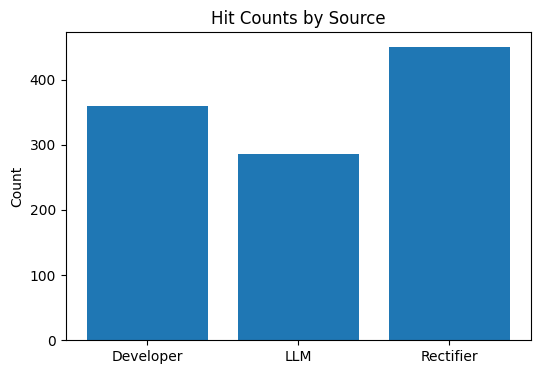

In [17]:
plt.figure(figsize=(6,4))
plt.bar(hit_data["Category"], hit_data["Hits"])
plt.title("Hit Counts by Source")
plt.ylabel("Count")
plt.show()

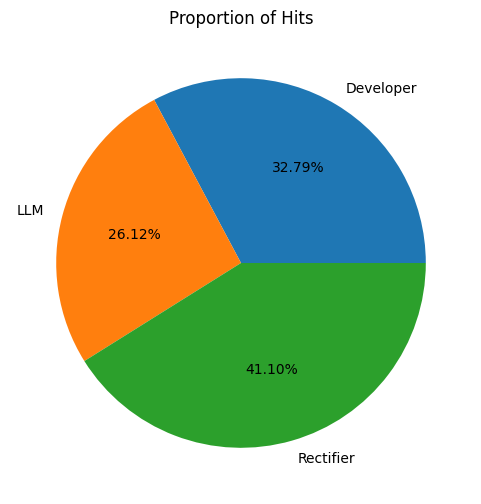

In [18]:
plt.figure(figsize=(6,6))
plt.pie(hit_data["Hits"], labels=hit_data["Category"], autopct='%1.2f%%')
plt.title("Proportion of Hits")
plt.show()